In [1843]:
from __future__ import print_function, division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle 
import ml_insights as mli


from sklearn.cross_validation import train_test_split, cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cross_validation import KFold

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.learning_curve import learning_curve
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score, make_scorer
from sklearn.metrics import recall_score, f1_score, roc_auc_score, roc_curve

In [881]:
# set the categories
category_dict = {'LC': 0, 'LR/LC': 0, 'VU': 2, 'NT': 1, 'LR/NT': 1, 'EN': 3, 'CR': 4, 'EX': 6, 'EW': 5}
hist_new_cat = map(lambda x: category_dict[x.upper()], hist_cat)
curr_new_cat = map(lambda x: category_dict[x.upper()], y_cat)

In [1379]:
y_diff_new = pd.Series(np.array(curr_new_cat) - np.array(hist_new_cat), index=y.index)
# pd.Series(y_diff_new).value_counts()
# y_diff_new[y_diff_new==5]
y_diff_new_bad = y_diff_new > 0
y_diff_new_better = y_diff_new < 0
y_new_change = y_diff_new != 0

In [1417]:
# load all the features/data
X = pickle.load( open( "X_features.p", "rb" ) )
y = pickle.load(open("y_label.p", "rb"))
y_diff = pickle.load(open("y_diff.p", "rb"))
y_change = pickle.load(open("y_change.p", "rb"))
y_cat = pickle.load(open("y_cat.p", "rb"))
hist_cat = pickle.load(open("hist_cat.p", "rb"))
countrydf = pickle.load(open("countrydf.p", "rb"))

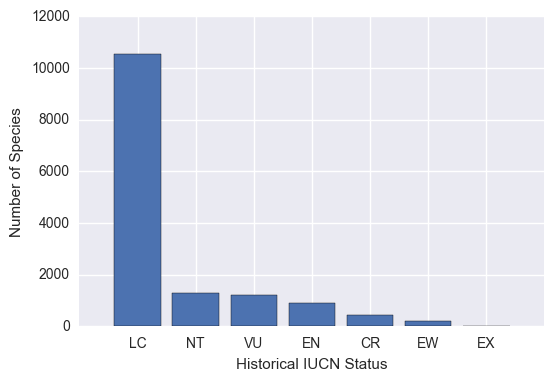

In [1975]:
plt.bar(range(len(pd.Series(hist_new_cat).value_counts())), pd.Series(curr_new_cat).value_counts(), align = 'center')
plt.xticks(range(len(pd.Series(curr_new_cat).value_counts())),['LC', 'NT', 'VU', 'EN', 'CR', 'EW', 'EX']);
plt.xlabel('Historical IUCN Status')
plt.ylabel('Number of Species')

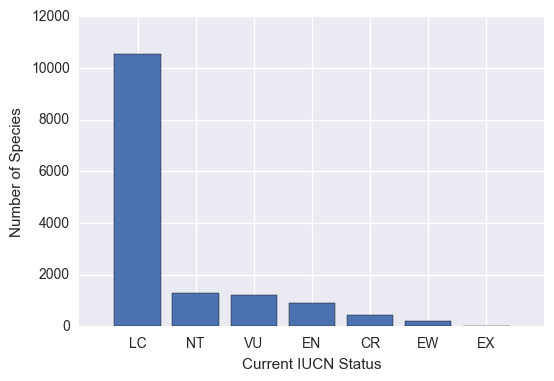

In [1973]:
plt.bar(range(len(pd.Series(curr_new_cat).value_counts())), pd.Series(curr_new_cat).value_counts(), align = 'center')
plt.xticks(range(len(pd.Series(curr_new_cat).value_counts())),['LC', 'NT', 'VU', 'EN', 'CR', 'EW', 'EX']);
plt.xlabel('Current IUCN Status')
plt.ylabel('Number of Species')

In [1381]:
# combine habitats into groups based on amount of rainfall 
hab_group_1 = (X[1] == 1) | (X[2] == 1) | (X[3]==1) | (X[4]==1)
hab_group_2 = (X[5] == 1) | (X[9] == 1)
hab_group_0 = (X[6] == 1) | (X[7] == 1) | (X[8] == 1)
hab_groups = pd.concat([pd.Series(hab_group_1), pd.Series(hab_group_2), pd.Series(hab_group_0)], axis=1)

In [1461]:
X_habgroup_nohist = pd.concat([X.iloc[:, 0:4], X.iloc[:, 13:16], hab_groups], axis=1)
X_habgroup = pd.concat([X.iloc[:, 0:4], X.iloc[:, 13:], hab_groups], axis=1)
X_new_hist_cat = pd.concat([X.iloc[:, 0:4], X.iloc[:, 13:16], pd.Series(hist_new_cat,index=y.index)], axis=1)
X_new_hist_cat_hab = pd.concat([X.iloc[:, 0:4], X.iloc[:, 13:16], pd.Series(hist_new_cat,index=y.index), hab_groups], axis=1)

In [1383]:
X_dummy = X.iloc[:,0:4]

In [1384]:
# set y for species that improved and worsen
y_diff_bad = y_diff>0
y_diff_better = y_diff < 0

In [1385]:
# accuracy by just guessing 'LC' (i.e. majority)
accuracy_score(['LC'] * len(y_test), y_test)

/Users/James/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:177: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


0.0

In [1386]:
# accuracy by just guessing 0 (i.e. no change)
accuracy_score(np.zeros(len(y_test)), y_test)

0.96780086777803154

In [1387]:
# accuracy by just guessing 0 (i.e. no change)
accuracy_score(np.zeros(len(y_test)), y_test)

0.96780086777803154

In [1660]:
# Distribution of our y (normalized)
y_diff_new.value_counts()/len(y_diff_new)

 0    0.936965
-1    0.022610
 1    0.021172
 2    0.008222
-2    0.006852
 3    0.002398
-3    0.001165
 4    0.000411
-4    0.000137
 5    0.000069
dtype: float64

In [2018]:
# used stratified test/train split
X_train, X_test, y_train, y_test = train_test_split(X_new_hist_cat_hab, y_new_change, test_size=0.3, stratify = y_new_change)

In [1872]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_y = rf_model.predict(X_test)
accuracy_score(rf_y, y_test)

0.9675725051381594

In [1833]:
recall_score(rf_y, y_test)

0.59390862944162437

In [1834]:
average_precision_score(rf_y, y_test)

0.51804534205482722

### Gradient Boosting

In [2019]:
gb_model = GradientBoostingClassifier(learning_rate=0.1)
a = gb_model.fit(X_train, y_train)
gb_y = gb_model.predict(X_test)
gb_prob = gb_model.predict_proba(X_test)
accuracy_score(gb_y, y_test)

0.94724823018954096

In [2020]:
np.mean(X_new_hist_cat_hab.loc[y_test.index[y_test!=gb_y]].country_count)

4.038961038961039

In [2021]:
np.mean(X_new_hist_cat_hab.loc[y_test.index[gb_y != y_test]].country_count)

4.038961038961039

In [2022]:
list(zip(X_new_hist_cat_hab, gb_model.feature_importances_))

[('country_count', 0.048368714752348364),
 ('forrest_mean', 0.19662758795510615),
 ('pop_mean', 0.29361446384693646),
 ('temp_mean', 0.15348305404018506),
 (u'AVES', 0.051039665123159779),
 (u'MAMMALIA', 0.011463300331499235),
 (u'REPTILIA', 0.018957921973983632),
 (0, 0.13996946527298637),
 ('bool_0', 0.045834588890309336),
 ('bool_1', 0.0093942649766397979),
 ('bool_2', 0.031246972836845948)]

In [2023]:
recall_score(gb_y, y_test)

0.63313609467455623

In [2024]:
average_precision_score(gb_y, y_test)

0.51748786888345866

In [2025]:
roc_auc_score(y_test, gb_prob[:,1])

0.95375688343983001

In [2026]:
prec, rec, thresh = precision_recall_curve(y_test,gb_prob[:,1])

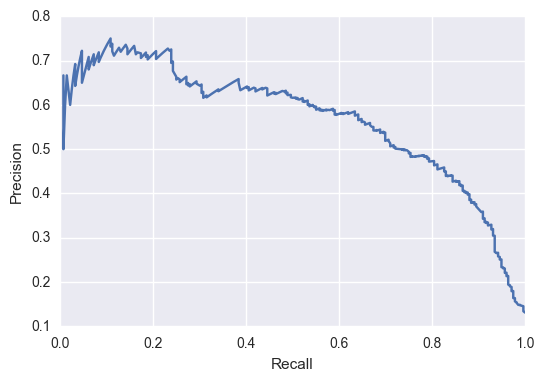

In [2035]:
%matplotlib inline
plt.plot(rec[:-3], prec[:-3])
plt.ylabel('Precision')
plt.xlabel('Recall')

### SVC (Support Vector Classification)

In [1796]:
sv_model = SVC()
sv_model.fit(X_train, y_train)
sv_y = sv_model.predict(X_test)
accuracy_score(sv_y, y_test)

0.97693537337291614

In [1797]:
recall_score(sv_y, y_test)

0.0

In [1798]:
average_precision_score(sv_y, y_test)

nan

### Logistic Regression

In [1690]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
lr_y = lr_model.predict(X_test)
lr_prob = lr_model.predict_proba(X_test)
accuracy_score(lr_y, y_test)

0.93468828499657453

In [1691]:
recall_score(lr_y, y_test)

0.36842105263157893

In [1692]:
average_precision_score(lr_y, y_test)

0.21231319683483457

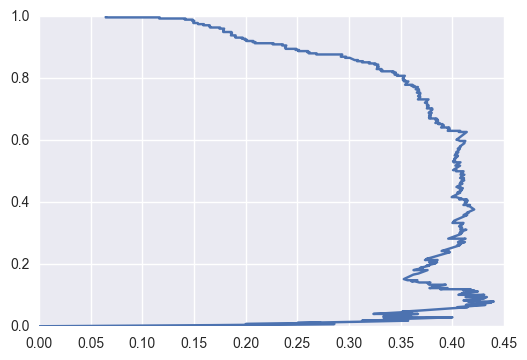

In [1693]:
prec, rec, thresh = precision_recall_curve(y_test,lr_prob[:,1])
plt.plot(prec[:-1], rec[:-1])

In [1219]:
X_cat = pd.concat([X, hist_cat], axis=1)

In [1220]:
# accuracy by just guessing history category (i.e. majority)
accuracy_score(hist_cat, y_cat)

0.90791366906474824

In [1221]:
X_trainc, X_testc, y_trainc, y_testc = train_test_split(X, y_cat, test_size=0.3, stratify = y_change)

In [1222]:
KNN_modelc = KNeighborsClassifier()
KNN_modelc.fit(X_trainc, y_trainc)
knn_yc = KNN_modelc.predict(X_testc)
accuracy_score(knn_yc, y_testc)

0.83809088833066914

In [1223]:
rf_modelc = RandomForestClassifier()
rf_modelc.fit(X_trainc, y_trainc)
rf_yc = rf_modelc.predict(X_testc)
accuracy_score(rf_yc, y_testc)

0.85293445992235672

In [1224]:
gb_modelc = GradientBoostingClassifier()
gb_modelc.fit(X_trainc, y_trainc)
gb_yc = gb_modelc.predict(X_testc)
gb_probc = gb_modelc.predict_proba(X_testc)
accuracy_score(gb_yc, y_testc)

0.87074674583238187

In [1424]:
bad_species_index = y_diff_new_bad[y_diff_new_bad].index.tolist()
good_species_index = y_diff_new_bad[y_diff_new_better].index.tolist()

In [1425]:
# Average number of countries that species that changed for the better/worse are found in
avg_count_bad = np.mean(countrydf.loc[bad_species_index].country_count)
avg_count_all = np.mean(countrydf.country_count)
avg_count_good = np.mean(countrydf.loc[good_species_index].country_count)
print(('good: {}, bad: {}, all: {}').format(avg_count_good, avg_count_bad, avg_count_all))

good: 4.04008908686, bad: 3.50955414013, all: 7.4748741238


### Preparation for D3

In [1609]:
country_mean = {}
country_var = {}
for species in y.index:
    country_arr = countrydf.loc[species].country_array
    for country in country_arr:
        if country in country_mean:
            num_species = country_mean[country][0] + 1
            sum_diff = country_mean[country][1] + y_diff_new.loc[species]
            country_var[country].append(y_diff_new.loc[species])
             
        else:
            num_species = 1
            sum_diff = y_diff_new.loc[species]
            country_var[country] = [y_diff_new.loc[species]]
        
        country_mean[country] = [num_species, sum_diff]
            
    

In [1619]:
country_d3_dict

{u'AD': -0.012500000000000001,
 u'AE': 0.0022371364653243847,
 u'AF': -0.0087108013937282226,
 u'AG': -0.018115942028985508,
 u'AI': -0.023809523809523808,
 u'AL': -0.002631578947368421,
 u'AM': 0.0080862533692722376,
 u'AO': 0.0035211267605633804,
 u'AQ': -0.011235955056179775,
 u'AR': 0.011041009463722398,
 u'AS': -0.064102564102564097,
 u'AT': 0.010548523206751054,
 u'AU': -0.0081743869209809257,
 u'AW': -0.023255813953488372,
 u'AZ': 0.0023201856148491878,
 u'BA': -0.002617801047120419,
 u'BB': -0.0034482758620689655,
 u'BD': -0.0013458950201884253,
 u'BE': 0.0021321961620469083,
 u'BF': 0.0071301247771836003,
 u'BG': 0.0,
 u'BH': -0.012903225806451613,
 u'BI': 0.0042016806722689074,
 u'BJ': 0.0078125,
 u'BL': 0.0,
 u'BM': -0.01444043321299639,
 u'BN': 0.019927536231884056,
 u'BO': 0.0024706609017912293,
 u'BQ': -0.031847133757961783,
 u'BR': 0.012368300503893724,
 u'BS': -0.031700288184438041,
 u'BT': -0.0072992700729927005,
 u'BV': -0.024390243902439025,
 u'BW': 0.008797653958944

In [1617]:
country_d3_var

{u'AD': 0.11110243021644488,
 u'AE': 0.19500337210148458,
 u'AF': 0.19107456082047541,
 u'AG': 0.24751972758338506,
 u'AI': 0.30768685674571628,
 u'AL': 0.15387425164256541,
 u'AM': 0.15554218917793541,
 u'AO': 0.17798242191690297,
 u'AQ': 0.28022390816494208,
 u'AR': 0.24777467928264624,
 u'AS': 0.33357979054506881,
 u'AT': 0.16527216642771211,
 u'AU': 0.39170141749835297,
 u'AW': 0.20327231054336889,
 u'AZ': 0.15973934550402327,
 u'BA': 0.15347102834659532,
 u'BB': 0.2815998121824041,
 u'BD': 0.24056532259387864,
 u'BE': 0.17882504346491904,
 u'BF': 0.11920323349233861,
 u'BG': 0.17078251276599329,
 u'BH': 0.13852200357150898,
 u'BI': 0.19441571934889534,
 u'BJ': 0.18941083613075044,
 u'BL': 0.13736056394868904,
 u'BM': 0.22435015073342018,
 u'BN': 0.25813151455599787,
 u'BO': 0.14056736125088992,
 u'BQ': 0.32751490782630421,
 u'BR': 0.2844786568861124,
 u'BS': 0.26653555342413521,
 u'BT': 0.14779895424318676,
 u'BV': 0.15425744683748191,
 u'BW': 0.16222072358873116,
 u'BY': 0.117655

In [1948]:
country_d3_dict = {}
country_d3_var = {}
country_counts = {}
for key, value in country_mean.iteritems():
    country_d3_dict[key] = country_mean[key][1]/country_mean[key][0]
    country_counts[key] = country_mean[key][0]
    country_d3_var[key] = np.std(country_var[key])


In [1949]:
country_d3_df = pd.DataFrame.from_dict(country_d3_dict, orient='index')
countrycounts_d3_df = pd.DataFrame.from_dict(country_counts, orient='index')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12fb9e5d0>]], dtype=object)

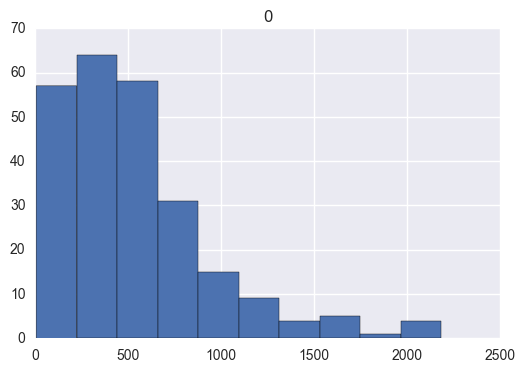

In [1953]:
countrycounts_d3_df.hist()

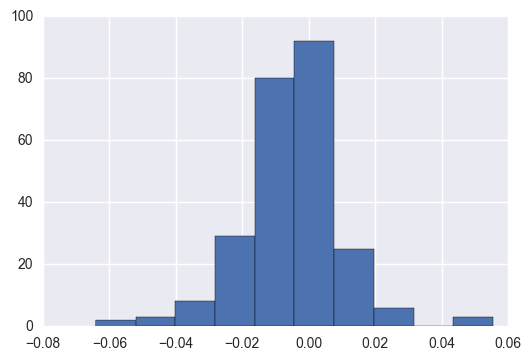

In [1945]:
country_d3_df.loc[:, 0].hist()

In [1546]:
crapcountries = country_d3_df[country_d3_df.loc[:,0]>0.02].index.tolist()

In [1580]:
country_d3_df

,0
BD,-0.001346
BE,0.002132
BF,0.007130
BG,0.000000
BA,-0.002618
BB,-0.003448
WF,-0.015385
BL,0.000000
BM,-0.014440
BN,0.019928


In [1597]:
country_codes

,ISO,ISO3,ISO-Numeric,fips,Country,Capital,Area(in sq km),Population,Continent,tld,CurrencyCode,CurrencyName,Phone,Postal Code Format,Postal Code Regex,Languages,geonameid,neighbours,EquivalentFipsCode
0,AD,AND,20,AN,Andorra,Andorra la Vella,468.00,84000,EU,.ad,EUR,Euro,376,AD,NaN,NaN,NaN,NaN,NaN
1,AE,ARE,784,AE,United Arab Emirates,Abu Dhabi,82880.00,4975593,AS,.ae,AED,Dirham,971,NaN,NaN,"ar-AE,fa,en,hi,ur",290557.0,"SA,OM",NaN
2,AF,AFG,4,AF,Afghanistan,Kabul,647500.00,29121286,AS,.af,AFN,Afghani,93,NaN,NaN,"fa-AF,ps,uz-AF,tk",1149361.0,"TM,CN,IR,TJ,PK,UZ",NaN
3,AG,ATG,28,AC,Antigua and Barbuda,St. John's,443.00,86754,NaN,.ag,XCD,Dollar,+1-268,NaN,NaN,en-AG,3576396.0,NaN,NaN
4,AI,AIA,660,AV,Anguilla,The Valley,102.00,13254,NaN,.ai,XCD,Dollar,+1-264,NaN,NaN,en-AI,3573511.0,NaN,NaN
5,AL,ALB,8,AL,Albania,Tirana,28748.00,2986952,EU,.al,ALL,Lek,355,NaN,NaN,"sq,el",783754.0,"MK,GR,ME,RS,XK",NaN
6,AM,ARM,51,AM,Armenia,Yerevan,29800.00,2968000,AS,.am,AMD,Dram,374,NaN,NaN,NaN,NaN,NaN,NaN
7,AO,AGO,24,AO,Angola,Luanda,1246700.00,13068161,AF,.ao,AOA,Kwanza,244,NaN,NaN,pt-AO,3351879.0,"CD,NA,ZM,CG",NaN
8,AQ,ATA,10,AY,Antarctica,NaN,14000000.00,0,AN,.aq,NaN,NaN,NaN,NaN,NaN,NaN,6697173.0,NaN,NaN
9,AR,ARG,32,AR,Argentina,Buenos Aires,2766890.00,41343201,SA,.ar,ARS,Peso,54,@,NaN,NaN,NaN,NaN,NaN


In [1598]:
country_codes= pd.read_table('countrycodeinfo.txt',comment='#')
country_convert_iso_to_num = country_codes[['ISO', 'ISO-Numeric', 'ISO3', 'Country']]

In [1956]:
country_d3_final = pd.merge(country_d3_df, country_convert_iso_to_num, right_on='ISO', left_index=True)
country_d3_species = pd.merge(countrycounts_d3_df, country_convert_iso_to_num, right_on='ISO', left_index=True)

In [1958]:
country_d3_final

,0,ISO,ISO-Numeric,ISO3,Country
18,-0.001346,BD,50,BGD,Bangladesh
19,0.002132,BE,56,BEL,Belgium
20,0.007130,BF,854,BFA,Burkina Faso
21,0.000000,BG,100,BGR,Bulgaria
16,-0.002618,BA,70,BIH,Bosnia and Herzegovina
17,-0.003448,BB,52,BRB,Barbados
243,-0.015385,WF,876,WLF,Wallis and Futuna
25,0.000000,BL,652,BLM,Saint Barthelemy
26,-0.014440,BM,60,BMU,Bermuda
27,0.019928,BN,96,BRN,Brunei


In [1600]:
country_d3_final # mean change in status per country

,0,ISO,ISO-Numeric,ISO3,Country
18,-0.001346,BD,50,BGD,Bangladesh
19,0.002132,BE,56,BEL,Belgium
20,0.007130,BF,854,BFA,Burkina Faso
21,0.000000,BG,100,BGR,Bulgaria
16,-0.002618,BA,70,BIH,Bosnia and Herzegovina
17,-0.003448,BB,52,BRB,Barbados
243,-0.015385,WF,876,WLF,Wallis and Futuna
25,0.000000,BL,652,BLM,Saint Barthelemy
26,-0.014440,BM,60,BMU,Bermuda
27,0.019928,BN,96,BRN,Brunei


In [1591]:
countrydf # animal found in which countries

,country_array,country_count
species_id,,
22687170,"[GT, HN, MX, NI, SV]",5
17879,[PG],1
164607,"[AM, AZ, IR, TM, TR]",5
61450,"[CY, LB, SY, TR]",4
164622,"[AM, SY, TR]",3
178546,"[KG, KZ, TJ, TM, UZ]",5
29691,"[AL, BG, GR, HR, HU, MK, RO, RS, SK, TR]",10
61451,"[EG, IL, JO, PS]",4
47760825,"[AR, BR]",2


In [1959]:
d3_country_color = country_d3_final[['ISO3', 'Country', 0]]
d3_country_counts = country_d3_species[['ISO3', 'Country', 0]]

In [1961]:
d3_country_color.columns = ['id', 'name', 'population']
d3_country_counts.columns = ['id', 'name', 'counts']


In [1962]:
d3_country_counts

,id,name,counts
18,BGD,Bangladesh,743
19,BEL,Belgium,469
20,BFA,Burkina Faso,561
21,BGR,Bulgaria,480
16,BIH,Bosnia and Herzegovina,382
17,BRB,Barbados,290
243,WLF,Wallis and Futuna,65
25,BLM,Saint Barthelemy,106
26,BMU,Bermuda,277
27,BRN,Brunei,552


In [1963]:
d3_country_color.to_csv('world_mean.csv')
d3_country_counts.to_csv('species_counts.csv')

### Looking into the model and feature importances

In [1893]:
X_new_hist_cat_hab.reset_index().iloc[:, 1:]

,country_count,forrest_mean,pop_mean,temp_mean,AVES,MAMMALIA,REPTILIA,0,0,1,2
0,5,-0.030843,0.038309,0.019611,1.0,0.0,0.0,0,True,False,False
1,1,-0.000572,0.164986,0.009266,0.0,1.0,0.0,0,True,False,False
2,4,0.017595,0.051593,0.024931,0.0,0.0,1.0,0,True,False,False
3,10,0.017198,-0.006011,0.026995,0.0,0.0,1.0,0,True,False,False
4,1,0.097775,0.078229,-0.017872,0.0,1.0,0.0,0,True,True,False
5,1,-0.042905,0.117167,0.013952,0.0,1.0,0.0,4,True,False,True
6,4,-0.008158,0.091507,0.002316,0.0,1.0,0.0,0,True,False,True
7,2,-0.035681,0.115453,-0.000299,0.0,0.0,1.0,3,True,False,False
8,2,-0.268076,0.225097,0.005460,0.0,0.0,1.0,4,True,False,False
9,10,0.006874,0.030461,0.011119,1.0,0.0,0.0,0,True,False,False


In [1920]:
X_new_hist_cat_hab

,country_count,forrest_mean,pop_mean,temp_mean,AVES,MAMMALIA,REPTILIA,0,bool_0,bool_1,bool_2
species_id,,,,,,,,,,,
22687170,5,-0.030843,0.038309,0.019611,1.0,0.0,0.0,0,True,False,False
17879,1,-0.000572,0.164986,0.009266,0.0,1.0,0.0,0,True,False,False
61450,4,0.017595,0.051593,0.024931,0.0,0.0,1.0,0,True,False,False
29691,10,0.017198,-0.006011,0.026995,0.0,0.0,1.0,0,True,False,False
42656,1,0.097775,0.078229,-0.017872,0.0,1.0,0.0,0,True,True,False
18,1,-0.042905,0.117167,0.013952,0.0,1.0,0.0,4,True,False,True
42657,4,-0.008158,0.091507,0.002316,0.0,1.0,0.0,0,True,False,True
63682,2,-0.035681,0.115453,-0.000299,0.0,0.0,1.0,3,True,False,False
20,2,-0.268076,0.225097,0.005460,0.0,0.0,1.0,4,True,False,False


In [1914]:
new_col_names = list(X_new_hist_cat_hab.columns[:-3])
new_col_names.extend(["bool_0", "bool_1", "bool_2"])

In [1916]:
X_new_hist_cat_hab.columns = new_col_names

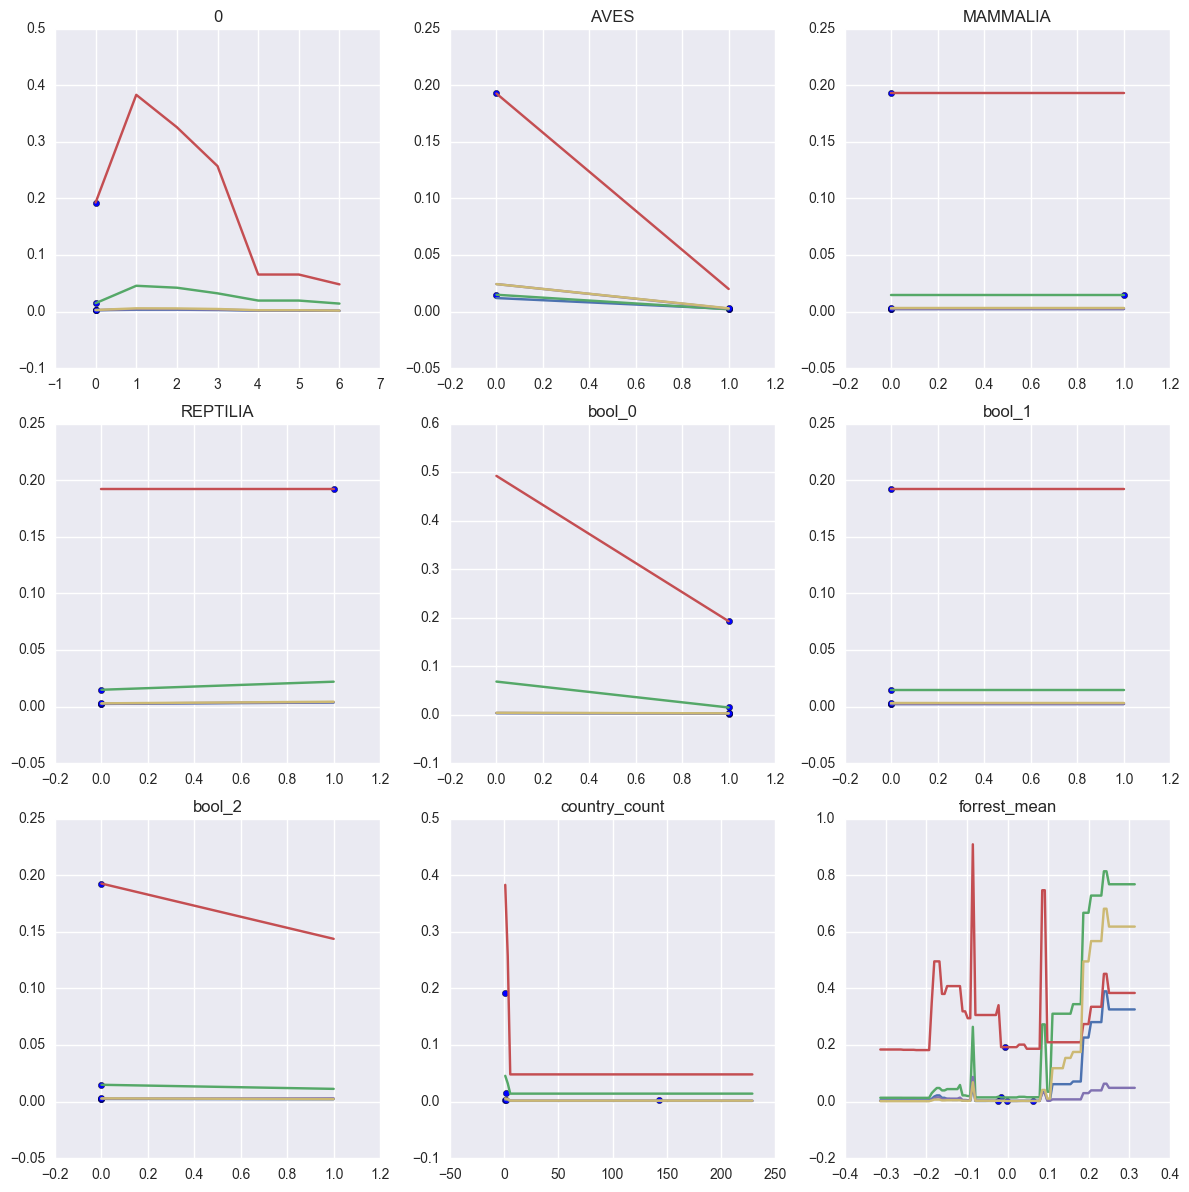

In [1918]:
mxr_rf = mli.ModelXRay(a,X_new_hist_cat_hab)
indices = mxr_rf.feature_dependence_plots(num_pts=5)

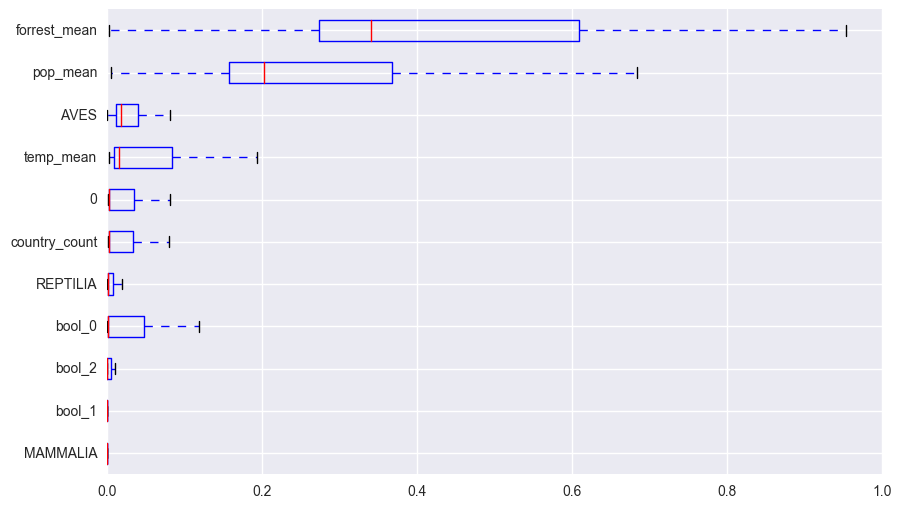

In [1919]:
mxr_rf.feature_effect_summary()

In [ ]:
### TRY UPSAMPLING!!